# Phase estimation algorithm

In this section we will look into the [phase estimation algorithm](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm), a necessary sub-routine in many quantum algorithms. The phase estimation algorithm allows us to estimate the eigenvalues of a given unitary operator. As the eigenvalues $\lambda$ of a unitary operator lie on the unit circle, they can be characterised solely by the phase $\theta$. 

Recall that a unitary operator $\hat{U}$ can be written in terms of a Hermitian operator $\hat{A}$ such that:

$$ \hat{U}|\Psi\rangle = e^{it\hat{A}}|\Psi\rangle. $$

If $|x\rangle$ is an eigenstate of $\hat{U}$, then:

$$ \hat{U}|x\rangle = \lambda|x\rangle = e^{2\pi i t \theta}|x\rangle, $$

and $\theta$ is additionally the eigenvalues of $\hat{A}$ with eigenstate $|x\rangle$, and where I have included the additional time evolution parameter $t_0$.

Phase estimation begins with two registers, one with the eigenstate $|x\rangle$, and the other we will use to estimate the phase, which we initialize into an initial superposition of $n$ qubits:

$$ |0\rangle^{\otimes n}|x\rangle \rightarrow \frac{1}{\sqrt{2^{n}}}\sum^{2^{n}-1}_{j=0}|j\rangle|x\rangle $$.

We can then perfrom a series of $n$ controlled rotations $\hat{U}^{-2^{k}}$ for $k=0,\dots,n-1$, resulting in the state:

$$ \frac{1}{\sqrt{2^{n}}}\sum^{2^{n}-1}_{j=0}|j\rangle|x\rangle \rightarrow \frac{1}{\sqrt{2^{n}}}\sum^{2^{n}-1}_{j=0}e^{-2\pi i t_0 \theta j}|j\rangle|x\rangle. $$.

The number of qubits $n$ should scale inversely with the conditioning number $\kappa$ of $\hat{A}$, equal to the ratio of the largest and smallest eigenvalues $\kappa=|\theta_{max}/\theta_{min}|$.
By now applying the inverse quantum Fourier transform onto the phase register, we recover the eigenvalues:

$$ \frac{1}{\sqrt{2^{n}}}\sum^{2^{n}-1}_{j=0}e^{-2\pi i t_0 \theta j}|j\rangle|x\rangle \rightarrow \frac{1}{2^{n}}\sum^{2^{n}-1}_{j=0}e^{-2\pi i t_0 \theta j}\sum^{2^{n}-1}_{k=0}e^{\frac{2\pi ijk}{2^{n}}}|k\rangle|x\rangle $$

such that:

$$ \frac{1}{2^{n}}\sum^{2^{n}-1}_{j=0}e^{-2\pi i t_0 \theta j}\sum^{2^{n}-1}_{k=0}e^{\frac{2\pi ijk}{2^{n}}}|k\rangle|x\rangle = \frac{1}{2^{n}}\sum^{2^{n}-1}_{j=0}\sum^{2^{n}-1}_{k=0}e^{\frac{2\pi ij}{2^{n}}(k-2^{n}t_0\theta)}|k\rangle|x\rangle $$.

This result strongly peaks at $k=\lfloor2^{n}t_0\theta\rfloor$, where $t$ can be chosen to avoid overflow errors. It can be shown that the measurement of the phase register will return the desired result at the given precision with probability greater than $4/\pi^2$.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import PhaseGate
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import random_hermitian
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

Let us consider an operator acting on $n_x=1$ qubits:

In [3]:
nx = 1

Let us consider a $2^{n_x}\times 2^{n_x}$ Hermitian matrix $A$ generated at random:

In [4]:
A = random_hermitian(2**nx).to_matrix()
print(A)

[[1.22449951+0.j         0.95158903+0.19165811j]
 [0.95158903-0.19165811j 0.13534563+0.j        ]]


We can dictate the probability of successfully obtaining the phase estimation by choosing the number of output qubits. Let us choose a success probability of:

In [5]:
p_suc = 0.95

then the number of ancillary qubits is chosen to be $n\ge n_x + \lceil\log_2(2 + \frac{1}{2(1-p_{suc}))}\rceil$:

In [6]:
phase = True

n = nx + int(np.ceil(np.log2(2. + 1./(2.*(1-p_suc)))))

print('The number of output qubits is set to',n)

The number of output qubits is set to 5


Let us cheat a little by calculating the exact minimum and maximum eigenvalues of this matrix in advance, as well as the conditioning number. In practice, the exact values would not be known but a general range of the eigenvalues can be roughly given.

In [7]:
lambda_min = np.real(np.min(np.linalg.eigvals(A)))
lambda_max = np.real(np.max(np.linalg.eigvals(A)))
kappa = np.abs(lambda_max/lambda_min)

print('Minimum eigenvalue, maximum eigenvalue and conditional number of A:', lambda_min, lambda_max, kappa)

Minimum eigenvalue, maximum eigenvalue and conditional number of A: -0.43309968730737863 1.7929448274452158 4.1397970951956164


The output register stores values between $0$ and $2^{n}-1$ (or $-2^{n-1}$ to $2^{n-1}-1$ if we consider storing the sign as well as the magnitude), which we wish to map to a range of values that correspond to the eigenvalues $\theta$. First we rescale the mangitudes given the relative magnitudes of the maximum and minimum eigenvalues $\kappa$. From this, we determine the number of integer qubits required to store this scaling:

In [8]:
# Calculate the new scale of the relative magnitudes of maximum and minimum eigenvalues
rescale = int((2**(n-phase)-1)/kappa)
# Make sure this scaling is not vanishingly small
if rescale < 1.e-7:
    rescale = 1
    
# determine the number of integer qubits required
nint = qt.get_nint(rescale)
# Assert that the number of integer qubits is equal to or greater than the number of ancillary qubits assigned
if nint < n - phase:
    nint = n - phase

We can determine the exact required evolution time $t_0$ to maximize observing outcomes that best correspond to the range of allowed eigenvalues, given the number of assigned output qubits as well as the minimum eigenvalue. This constant scales the minimum eigenvalue to the minimum range of the output register:

In [9]:
t0 = qt.bin_to_dec(qt.my_binary_repr(rescale, nint=nint, n=nint, phase=False), nint=0, phase=False) / (lambda_min * (2**phase))
t = 2 * np.pi * t0

Let us prepare a circuit to now perform the phase estimation. For this we will need a register to hold $|x\rangle$ and the output register to hold the predicted phase:

In [10]:
qreg = QuantumRegister(nx, 'x')
qout = QuantumRegister(n, 'out')
circ = QuantumCircuit(qreg, qout)

We can define the unitary operator $\hat{U}$ based upon our Hermitian matrix $A$ and the time evolution parameter $t$. Optimal implementations of a given unitary operator will depend on the form of $A$, which we will not consider here.

In [11]:
A_gate = HamiltonianGate(A, t)

We will apply a Hadammard gate to the $x$ register to allow us to infer both eigenvalues, before applying the phase estimation operation:

In [12]:
circ.h(qreg[0]);
circ = qt.PhaseEst(circ, qreg, qout, A_gate)

Here is the form of the phase estimation circuit as described in the introduction:

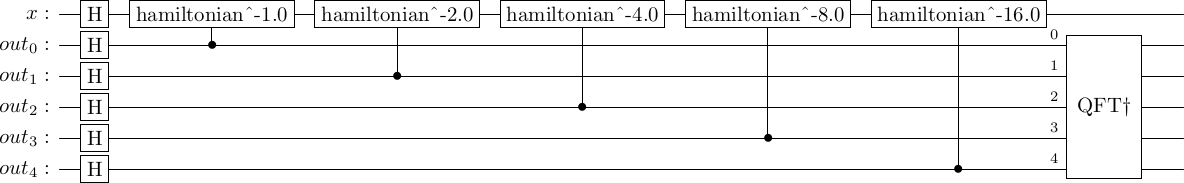

In [13]:
circ.draw('latex')

In [14]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

Let us retreive the state vector and marginalize out the $x$ register by summing over the amplitudes and renormalising:

In [15]:
state_v = np.asarray(state_vector).reshape((2**n,2**nx)).T
state_v = np.sum(state_v, axis=0)
state_v = state_v/np.sqrt(np.sum(np.abs(state_v)**2))

The output of the quantum Fourier transform is in a twos-complement notation which we can interpret by reindexing with `np.fft.fftfreq` and rescale according to the $2^{n}t$:

In [16]:
xs = np.fft.fftfreq(2**n,2.**(-n))/(t0*2**(n))

The corresponding state amplitudes and probabilities of retreiveing different estimations of the eigenvalues are shown in the plots below, where the dashed line corresponds to the minimum eigenvalue and the dotted line to the maximum eigenvalue:

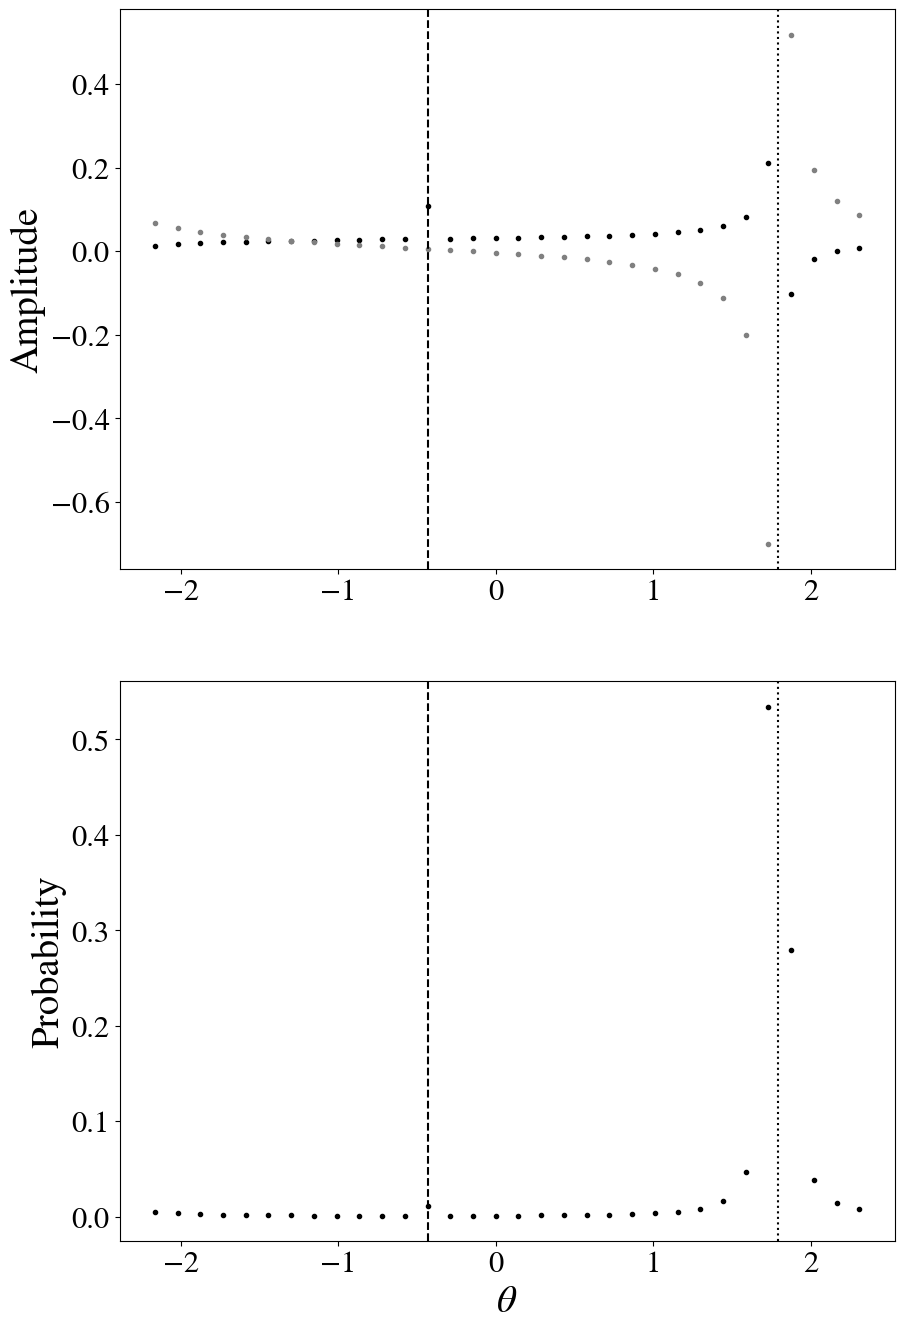

In [17]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.scatter(xs, state_v.real, marker='.', color='black')
plt.scatter(xs, state_v.imag, marker='.', color='grey')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax.axvline(lambda_min, ls='--', color='black')
ax.axvline(lambda_max, ls=':', color='black')

ax = fig.add_subplot(212)

plt.scatter(xs, np.abs(state_v)**2, marker='.', color='black')
ax.set_xlabel(r'$\theta$', fontsize=fontsize);
ax.set_ylabel('Probability', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax.axvline(lambda_min, ls='--', color='black')
ax.axvline(lambda_max, ls=':', color='black')

plt.show()

There *should* be good agreement between the true eigenvalues and the peaks of the probability distributions, where the true eigenvalues coincide with an outcome precisely for the minimum eigenvalue, and the true maximum eigenvalue is struddled by two high probability outcomes with probability proportional to their proximity to the true value.

**Future work:** why do the peaks not always align in some cases? Is there something wrong with the determination of $t_0$ in some cases? The determination of $t_0$ needs more thought.